# District {}

In [1]:
%%capture

import numpy as np
import pandas as pd
from siuba import *

import altair as alt
import altair_saver
from plotnine import *

from IPython.display import Markdown, HTML, Image
import ipywidgets as widgets
from ipywidgets import interact, interactive

from shared_utils import altair_utils
from shared_utils import geography_utils
from shared_utils import calitp_color_palette as cp
from shared_utils import styleguide

from calitp import to_snakecase
import intake

import _dla_utils




E0420 21:35:04.184271668    4600 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0420 21:35:04.666932757    4600 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


In [2]:
#Parameter Cell

district = 4

In [3]:
df= pd.read_parquet("dla_df.parquet")


In [4]:
df = (df>>filter(_.dist==district))
    
    
#subsetting the data
df_years = _dla_utils.count_all_years(df)
df_top = _dla_utils.find_top(df)
    

In [5]:
display(HTML("<h2>Quick Stats</h2>"))

display(
    HTML(
        f"There are <strong>{(df.primary_agency_name.nunique())} Unique Agencies</strong>"
    )
)

transit = df >> filter(_.transit == 1)

display(
    HTML(
        f"Out of <strong>{len(df)}</strong> obligations, <strong>{len(transit)} are transit-related</strong>."
    )
)
display(
    HTML(
        f"<strong>{(transit>>count(_.primary_agency_name)>>arrange(-_.n)).iloc[0, 0]}</strong> has the <strong>highest transit</strong> obligations"
    )
)

q = df >> count(_.primary_agency_name) >> arrange(_.n)

q2 = q.n.quantile(0.95)

display(
    HTML(
        f"There are <strong>{len(q>>filter(_.n> (q2)))} agencies have over {('%.2f'%(q2))}</strong> obligations (95th percentile) since {(df.prepared_y.min())}"
    )
)

q3 = q.n.quantile(0.1)
display(
    HTML(
        (
            f"There are <strong>{len(q>>filter(_.n< (q3)))} agencies have less than {('%.2f'%(q3))}</strong> obligations (5th percentile) since {(df.prepared_y.min())}"
        )
    )
)

## tables
display(HTML("<h4><strong>Number of Unique Prefix Codes by Agency</strong></h4>"))
display(
    (_dla_utils.get_nunique(df, "prefix", "primary_agency_name"))
    .rename(
        columns={"primary_agency_name": "Agency", "n": "Number of Unqiue Prefix Codes"}
    )
    .head(5)
)

display(HTML("<h4><strong>Number of Unique Agencies by Prefix Codes</strong></h4>"))
display(
    (_dla_utils.get_nunique(df, "primary_agency_name", "prefix"))
    .rename(columns={"prefix": "Prefix", "n": "Number of Unqiue Agencies"})
    .head(5)
)

display(HTML("<h4><strong>Top 5 Types of Work</strong></h4>"))
work_types = (
    (df >> count(_.type_of_work) >> arrange(-_.n) >> select(_.type_of_work))
    .rename(columns={"type_of_work": "Type of Work"})
    .head(5)
)
display(work_types.style)

,Agency,Number of Unqiue Prefix Codes
28,Contra Costa County,18
107,San Francisco County,17
110,San Jose,17
119,Santa Clara County,17
2,Alameda County,16


,Prefix,Number of Unqiue Agencies
91,STPL,112
19,CML,90
62,HSIPL,52
16,BRLS,32
75,RPSTPL,30


,Type of Work
378,FTA Transfer
109,Bridge Replacement
990,Road Rehabilitation
695,Pavement Rehabilitation
1062,Seismic Retrofit


In [6]:
 #Visual Charts

display(Markdown("<h2> Number of Obligations </h2>"))

<h2> Number of Obligations </h2>

In [7]:
 #Line chart for Obligations by Year
chart_df = (df_top>>filter(_.variable=='prepared_y')).rename(columns= {"value":"Year"})
    
chart1= (_dla_utils.basic_line_chart_test_no_save(chart_df, 'Year', 'count', district)).encode(x=alt.X('Year:O', title='Prepared Year'))
    
display(HTML("<h4><strong>Obligations by Year</strong></h4>"))
display(chart1)

alt.Chart(...)

In [8]:
# Unique Agencies by Dist
dist_years_agency = ((
        df
        >> group_by(_.prepared_y, _.dist)
        >> summarize(n=_.primary_agency_name.nunique())
        >> arrange(-_.prepared_y)
    )
        .rename(columns={'dist':'District', 'n':'Count'})
    )
chart10 = (alt.Chart(dist_years_agency).mark_bar().encode(
        column='District:N',
        x=alt.X('prepared_y:O', title='Prepared Year'),
        y=alt.Y('Count:Q', title='Number of Unique Agencies'),
        color = alt.Color("District:N", 
                              scale=alt.Scale(
                                  range=altair_utils.CALITP_SEQUENTIAL_COLORS),  
                               legend=alt.Legend(title="Prepared Year")
                              )))
                              
chart10 = styleguide.preset_chart_config(chart10)
chart10 = _dla_utils.add_tooltip(chart10, 'prepared_y', 'Count')
    
display(HTML("<h4><strong>Number of Unique Agencies by District</strong></h4>"))
display(chart10)

alt.Chart(...)

In [9]:
#Bar chart Agencies With The Most Obligations
chart_df = (df_top>>filter(_.variable=='primary_agency_name')).rename(columns={"value":"Agency",
                                 "count":"Number of Obligations"})
chart2 = (_dla_utils.basic_bar_chart_no_save(chart_df, 'Agency', 'Number of Obligations', 'Agency', district))
    
display(HTML("<h4><strong>Agencies With The Most Obligations</strong></h4>"))
display(chart2)


alt.Chart(...)

In [10]:
display(HTML("<h2>Prefix Codes</h2>"))

In [11]:
#Unique Prefixes by Dist
dist_years_prefix = ((
        df
        >> group_by(_.prepared_y, _.dist)
        >> summarize(n=_.prefix.nunique())
        >> arrange(-_.prepared_y)
    ).rename(columns={'dist':'District', 'n':'Count'}))

chart11 = (alt.Chart(dist_years_prefix).mark_bar().encode(
        column='District:N',
        x=alt.X('prepared_y:O', title='Prepared Year'),
        y=alt.Y('Count:Q', title='Number of Unique Agencies'),
        color = alt.Color("District:N", 
                              scale=alt.Scale(
                                  range=altair_utils.CALITP_SEQUENTIAL_COLORS),  
                               legend=alt.Legend(title="District")
                              )
                              ))
chart11 = styleguide.preset_chart_config(chart11)
chart11 = _dla_utils.add_tooltip(chart11, 'prepared_y','Count')
    
display(HTML("<h4><strong>Number of Unique Prefix Codes by District</strong></h4>"))
display(chart11)

alt.Chart(...)

In [12]:
#Bar chart with the Most Used Prefix Counts
chart_df = (df_top>>filter(_.variable=='prefix')).rename(columns={"value":"Prefix",
                                 "count":"Number of Obligations"})
chart9= (_dla_utils.basic_bar_chart_no_save(chart_df, 'Prefix', 'Number of Obligations', 'Prefix', district))
    
display(HTML("<h4><strong>Most Used Prefix Codes</strong></h4>"))
display(chart9)
    

alt.Chart(...)

In [13]:
#Bar chart Agencies With The Most Unique Prefix Codes
    
chart3 = (_dla_utils.basic_bar_chart_no_save(((_dla_utils.get_nunique(df, 'prefix', 'primary_agency_name')).head(30)),
                            'primary_agency_name', 'n', 'primary_agency_name', district))
    
display(HTML("<h4><strong>Agencies With The Most Unique Prefix Codes</strong></h4>"))
display(chart3)

alt.Chart(...)

In [14]:
display(HTML("<h2>Funding Distribution</h2>"))

In [15]:
#Bar chart Average Total Requested Funds by Agency
chart4=(_dla_utils.basic_bar_chart_no_save((((_dla_utils.calculate_data_all(df, 'adjusted_total_requested', 'primary_agency_name', aggfunc="mean"))
                          >>arrange(-_.adjusted_total_requested)).head(30)
                        ), 'primary_agency_name','adjusted_total_requested', 'primary_agency_name', district
                          
                       ))
    
display(HTML("<h4><strong>Average Total Requested Funds by Agency ($2021)</strong></h4>"))
display(chart4)

alt.Chart(...)

In [16]:
#Bar chart Bottom Average Total Requested Funds by Agency
avg_funds_bottom = (df>>group_by(_.primary_agency_name)>>summarize(avg_funds=_.adjusted_total_requested.mean())>>arrange(-_.avg_funds)).tail(50)

chart5=( _dla_utils.basic_bar_chart_no_save((avg_funds_bottom.tail(40)), 'primary_agency_name','avg_funds', 'primary_agency_name', district))
    
display(HTML("<h4><strong>Lowest Average Total Funds by Agency ($2021)</strong></h4>"))
display(chart5)

alt.Chart(...)

In [17]:
# Bar chart Average Total Requested Funds by Prefix
chart8 = (_dla_utils.basic_bar_chart_no_save((((_dla_utils.calculate_data_all(df, 'adjusted_total_requested', 'prefix', aggfunc="mean"))
                          >>arrange(-_.adjusted_total_requested)).head(30)), 'prefix','adjusted_total_requested', 'prefix', district
                       ))
    
display(HTML("<h4><strong>Average Total Requested Funds by Prefix ($2021)</strong></h4>"))
display(chart8)
    

alt.Chart(...)

In [18]:
#work categories info and charts
display(HTML("<h2>Work Categories</h2>"))

In [23]:
 # code help: https://stackoverflow.com/questions/50842160/how-to-display-matplotlib-plots-in-a-jupyter-tab-widget
    
work_cat = ['active_transp', 'transit', 'bridge', 'street','freeway', 'infra_resiliency_er','congestion_relief']

out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()
out4 = widgets.Output()
out5 = widgets.Output()
out6 = widgets.Output()
out7 = widgets.Output()

    # children2 = [widgets.Text(description=name) for name in work_cat]
    # tab2 = widgets.Tab(children2)
tab2 = widgets.Tab(children = [out1, out2, out3, out4, out5, out6, out7])

for ii in enumerate(work_cat): 
    tab2.set_title(ii[0], f"{_dla_utils.labeling(ii[1])}")

display(tab2)
    
    
# with out1:
#     _dla_utils.project_cat(df, 'active_transp', district) 

out1.append_display_data(_dla_utils.project_cat(df, 'active_transp', district))
out1.append_display_data(Image(filename=(f'./chart_outputs/project_cat/bar_{district}_active_transp.png')))

with out2:
     _dla_utils.project_cat(df, 'transit', district)
with out3: 
     _dla_utils.project_cat(df, 'bridge', district)
with out4:
    _dla_utils.project_cat(df, 'street', district)
with out5:
     _dla_utils.project_cat(df, 'freeway', district)
with out6:
    _dla_utils.project_cat(df, 'infra_resiliency_er', district)
with out7:
    _dla_utils.project_cat(df, 'congestion_relief', district)
    

E0420 21:37:30.780389686    4600 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0420 21:37:30.804653516    4600 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0420 21:37:30.829419762    4600 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0420 21:37:31.170382813    4600 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


HTML(value='<h3> Top Agencies using Active Transportation Projects </h3>')

,Agency,Active Transportation Obligations,Percent of Category
0,San Jose,79,7.35%
1,Oakland,65,6.05%
2,"City & County of San Francisco, MTA/Parking & Traffic",46,4.28%
3,Sunnyvale,45,4.19%
4,Contra Costa County,39,3.63%


In [20]:
# work_cat = ['active_transp', 'transit', 'bridge', 'street','freeway', 'infra_resiliency_er','congestion_relief']

# out1 = widgets.Output()
# out2 = widgets.Output()
# out3 = widgets.Output()
# out4 = widgets.Output()
# out5 = widgets.Output()
# out6 = widgets.Output()
# out7 = widgets.Output()

# tab2 = widgets.Tab(children = [out1, out2, out3, out4, out5, out6, out7])

# for ii in enumerate(work_cat): 
#     tab2.set_title(ii[0], f"{_dla_utils.labeling(ii[1])}")

# display(tab2)
    
# with out1:
#     _dla_utils.project_cat(df, 'active_transp', district) 
# with out2:
#      _dla_utils.project_cat(df, 'transit', district)
# with out3: 
#      _dla_utils.project_cat(df, 'bridge', district)
# with out4:
#     _dla_utils.project_cat(df, 'street', district)
# with out5:
#      _dla_utils.project_cat(df, 'freeway', district)
# with out6:
#     _dla_utils.project_cat(df, 'infra_resiliency_er', district)
# with out7:
#     _dla_utils.project_cat(df, 'congestion_relief', district)
    
    
## https://medium.com/analytics-vidhya/how-to-use-python-to-build-an-image-display-app-in-jupyter-notebook-337c4fd3775f
def show_im():
    CSS = """
    .output {
        flex-direction: row;
    }
    """
    HTML('<style>{}</style>'.format(CSS))

def image_viewer(district, i): 
    image_grid = Image(filename=(f'./chart_outputs/project_cat/bar_{district}_{i}.png'))
    #image_grid_html = HTML(image_grid.to_html(escape=False ,formatters=dict(a=path_to_image_html, 
    #b=path_to_image_html)))
    #display(image_grid_html)
    show_im()    
    

tab_nest = widgets.Tab()


#interact function in isolation

image = (image_viewer(district, 'active_transp'))
f1 = interactive(image);
tab_nest.children = [widgets.VBox(children = f1.children)]
display(tab_nest)

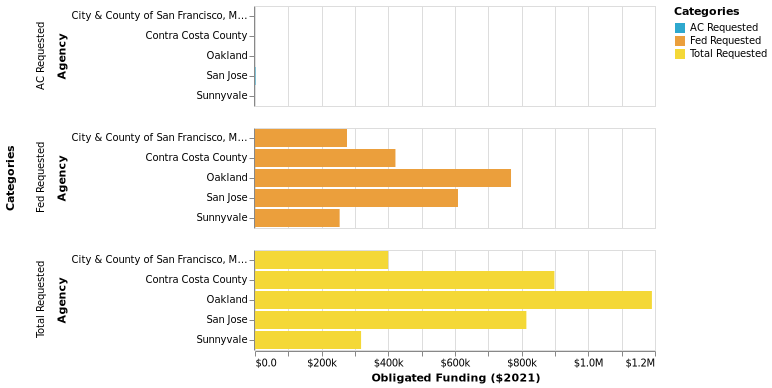

In [21]:
Image(filename=('./chart_outputs/project_cat/bar_4_active_transp.png'))

![pic](./chart_outputs/project_cat/bar_4_active_transp.png)